![title](Logo1.jpeg)

# <center> Risco dos bairros de Salvador ao espalhamento do COVID-19 decorrente da circulação de pessoas e condições socioeconômicas </center>
## Grupo GeoCombate COVID-19 BA
### Autor do Código: Prof. Jorge Ubirajara Pedreira Junior (Escola Politécnica da Universidade Federal da Bahia - EPUFBA)

**Carregamento de bibliotecas:**

In [1]:
# Display all results in a single notebook input:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import pysal
from pyproj import CRS
from shapely.geometry import Point, MultiPoint, Polygon, mapping
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from fiona.crs import from_epsg
import pickle

C:\Users\Jorge\Anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\Jorge\Anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# (1) Leitura dos Arquivos

**(a) Zonas de Tráfego:**

In [3]:
zt = gpd.read_file("RMS_ODSAD69.shp")
zt = zt.to_crs(CRS("WGS84"));

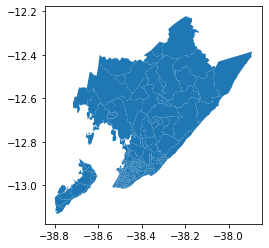

In [4]:
zt.plot();
plt.show();

**(b) Bairros:**

In [5]:
nb = gpd.read_file("Bairros_Lei_9278_2017.shp")
nb = nb.to_crs(CRS("WGS84"));

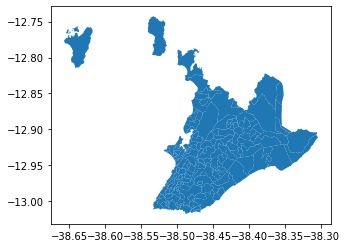

In [6]:
nb.plot();
plt.show();

In [7]:
zt.crs == nb.crs

True

**(c) Fluxos de tráfego:**

Pesquisa OD 2012:

In [8]:
f2012 = pd.read_excel("OD_TC_Trab.xlsx", decimal = ",")
f2012['ORIG'] = f2012['ORIG'].astype(str)
f2012['DEST'] = f2012['DEST'].astype(str)

**(d) Casos COVID-2 por bairro:**

In [9]:
diario = pd.read_excel('diario.xlsx')
diario.head()

,Bairro,d20200322,d20200323
0,Pituba,5,6
1,Graça,3,4
2,Barra,0,2
3,Brotas,4,7
4,Caminho das Árvores,1,1


**(e) UDH (IPEA):**

In [10]:
udh = gpd.read_file("RM_Salvador_UDH.shp")

In [11]:
udh.head()

,UDH_ATLAS,CODIGO_MUN,NM_MUNICIP,REGIONAL,geometry
0,1290570100001,2905701,CAMAÇARI,None,"POLYGON ((605293.025 8607228.855, 605293.016 8..."
1,1290570100002,2905701,CAMAÇARI,None,"POLYGON ((597467.133 8597477.329, 597429.598 8..."
2,1290570100003,2905701,CAMAÇARI,None,"POLYGON ((577898.442 8578422.528, 577883.987 8..."
3,1290570100004,2905701,CAMAÇARI,None,"POLYGON ((579766.331 8581002.023, 579586.226 8..."
4,1290570100007,2905701,CAMAÇARI,None,"POLYGON ((588544.734 8587173.277, 588433.893 8..."


In [12]:
udh = udh.to_crs(CRS("WGS84"));
udh.crs == nb.crs

True

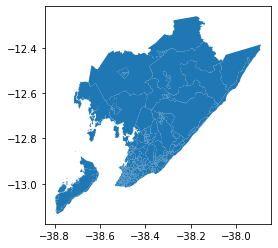

In [13]:
udh.plot();
plt.show();

# (2) Computando os parâmetros:

**(a) Áreas dos Bairros:**

In [14]:
SB = list(nb.area)

**(b) Áreas das Zonas de Tráfego:**

In [15]:
SZ = list(zt.area)

**(c) Áreas das interseções entre bairros e zonas de tráfego:**

In [16]:
I = np.zeros((len(zt),len(nb)))

In [17]:
for i in np.arange(len(zt)):
    for j in np.arange(len(nb)):
        I[i,j] = zt.loc[i,'geometry'].intersection(nb.loc[j,'geometry']).area

**(d) Fluxos:**

2012:

In [18]:
#ft_2012 = np.zeros((len(zt),len(zt)))
#for i in np.arange(len(zt)):
#    for j in np.arange(len(zt)):
#        try:
#            ft_2012[i,j] = float(f2012[(f2012['ORIG'] == zt.loc[i,'ID']) & (f2012['DEST'] == zt.loc[j,'ID'])].VIAG)
#        except:
#            ft_2012[i,j] = 0
#pickle.dump(ft_2012, open('ft_2012', 'wb'))

In [19]:
ft = pickle.load(open('ft_2012','rb'))

**(e) Prevalência de COVID-19:**

In [20]:
pop_ssa = pd.read_excel("pop_ssa.xlsx", decimal = ",")
pop_ssa.head()

,Código,Bairro,Cod_Pref,Periodo,Area_m²,Pop_Total,Pop_H%,Pop_M%,Dens_Dmgf,Pop50-64%,Pop>65%,Pop>50%,Pop50-64,Pop>65,Tot>50
0,1,Acupe,14,2010,512476.74,11213,0.4575,0.5425,218.80,0.1535,0.0777,0.2312,1721.1955,871.2501,2592.4456
1,2,Aeroporto,59,2010,10116033.63,0,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,3,Águas Claras,40,2010,3548530.06,37029,0.4866,0.5134,104.35,0.0987,0.0302,0.1289,1106.7231,338.6326,1445.3557
3,4,Alto da Terezinha,29,2010,943053.59,14010,0.4719,0.5281,148.56,0.1138,0.0442,0.1580,1276.0394,495.6146,1771.6540
4,5,Alto das Pombas,91,2010,133995.77,3823,0.4476,0.5524,285.32,0.1324,0.0672,0.1996,1484.6012,753.5136,2238.1148


In [21]:
nb['pop'] = 0
for index, row in pop_ssa.iterrows():
    try:
        nb.loc[nb['Nome_Bairr']==row['Bairro'],'pop'] = row['Pop_Total']
    except:
        "{} not in neighborhood list".format(row['Bairro'])

In [22]:
nb['c'] = 0
for index, row in diario.iterrows():
    try:
        nb.loc[nb['Nome_Bairr']==row['Bairro'],'c'] = row['d20200323']
    except:
        "{} not in neighborhood list".format(row['Bairro'])

In [23]:
for i in np.arange(len(nb)):
    if nb.loc[i,'pop'] > 0:
        nb.loc[i,'prev'] = nb.loc[i,'c']/nb.loc[i,'pop']
    else:
        nb.loc[i,'prev'] = 0

# (3) Cálculo da Suscetibilidade dos Bairros em decorrência da mobilidade:

**(a) Cálculo do Potencial de Espalhamento do COVID-19 das zonas:**

In [24]:
P = [None] * len(zt)

In [25]:
for i in np.arange(len(zt)):
    P[i] = sum([x * y / SZ[i] for x, y in zip(nb['prev'],I[i,])])

In [26]:
zt['P'] = P

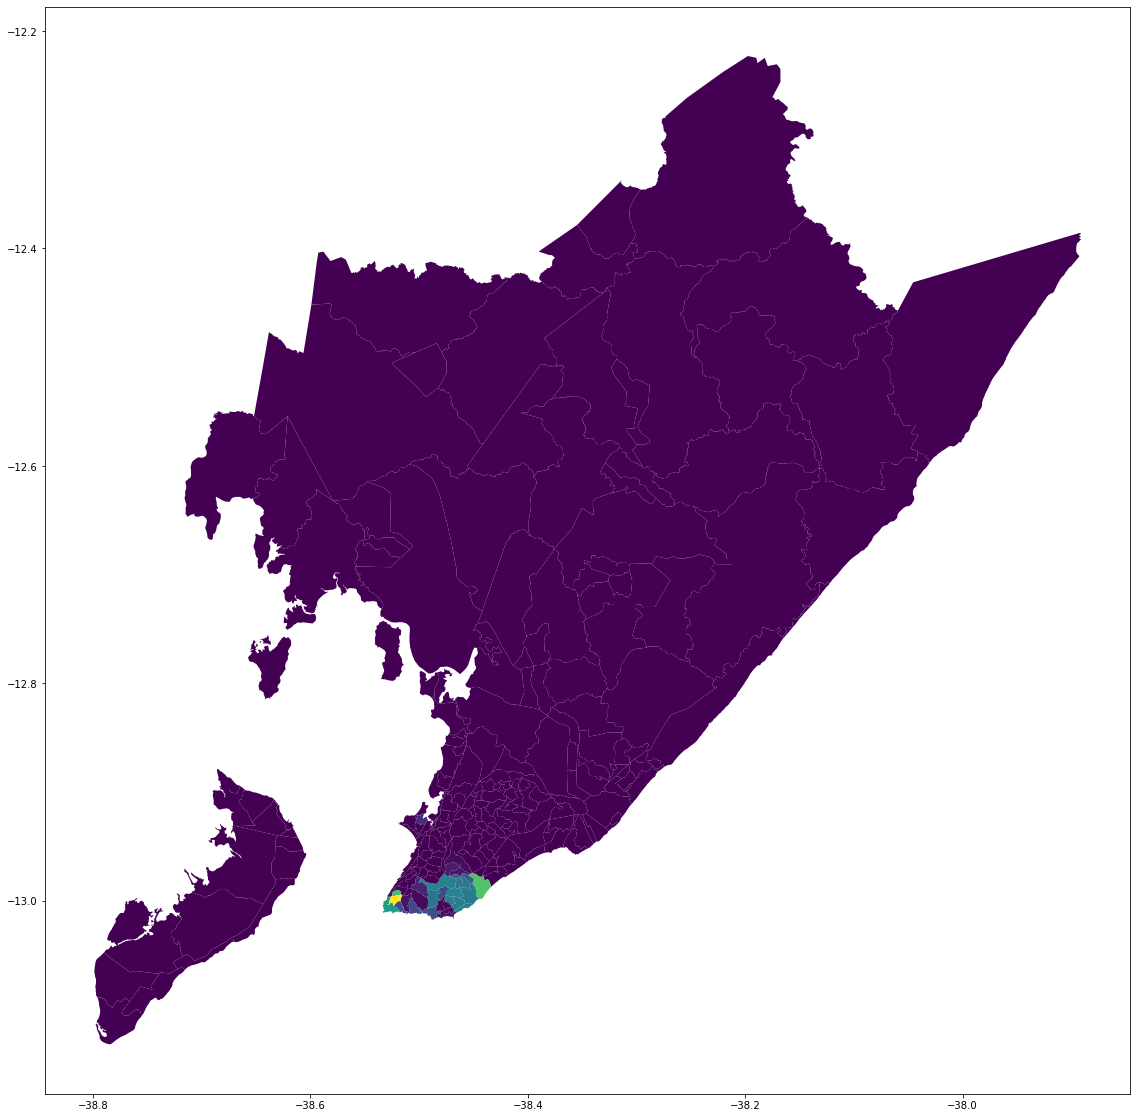

In [27]:
fig, ax = plt.subplots(figsize = [20,20])
zt.plot(ax = ax, column='P');
plt.show();

**(b) Cálculo da Potencial Absorção de COVID-19 das zonas:**

In [28]:
A = [None] * len(zt)

In [29]:
for j in np.arange(len(zt)):
    A[j] = sum([x * y for x, y in zip(ft[:,j],P)]) + sum([x * y for x, y in zip(ft[j,:],P)])

In [30]:
zt['A'] = A

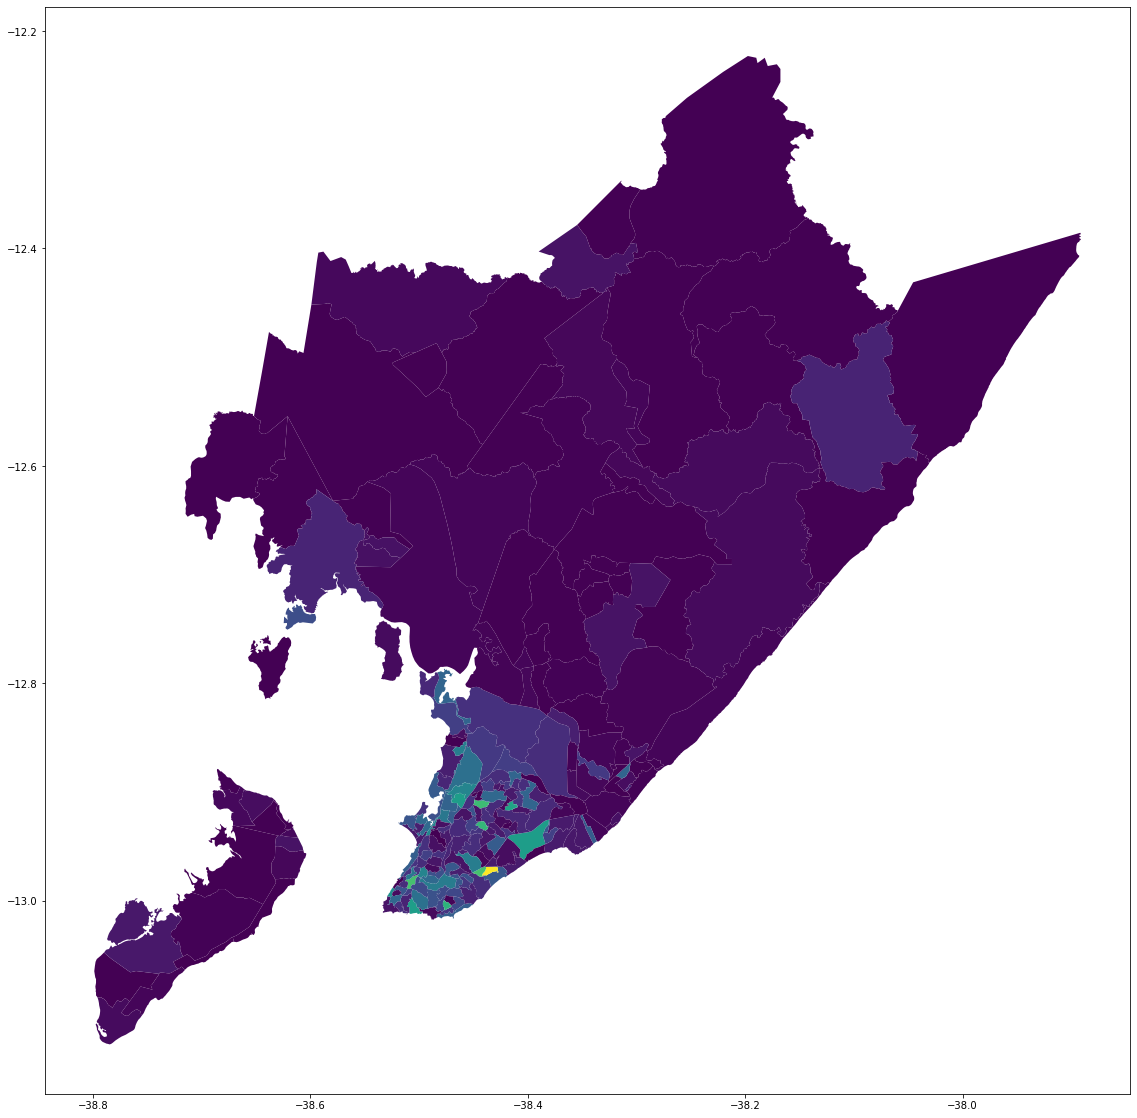

In [31]:
fig, ax = plt.subplots(figsize = [20,20])
zt.plot(ax = ax, column='A');
plt.show();

**(c) Cálculo da Perigo Potencial dos bairros:**

In [32]:
PP = [None] * len(nb)

In [33]:
for b in np.arange(len(nb)):
    PP[b] = sum([x * y /SB[b] for x, y in zip(A,I[:,b])])

In [34]:
PP = (PP-min(PP))/(max(PP)- min(PP))

In [35]:
nb['PP'] = PP

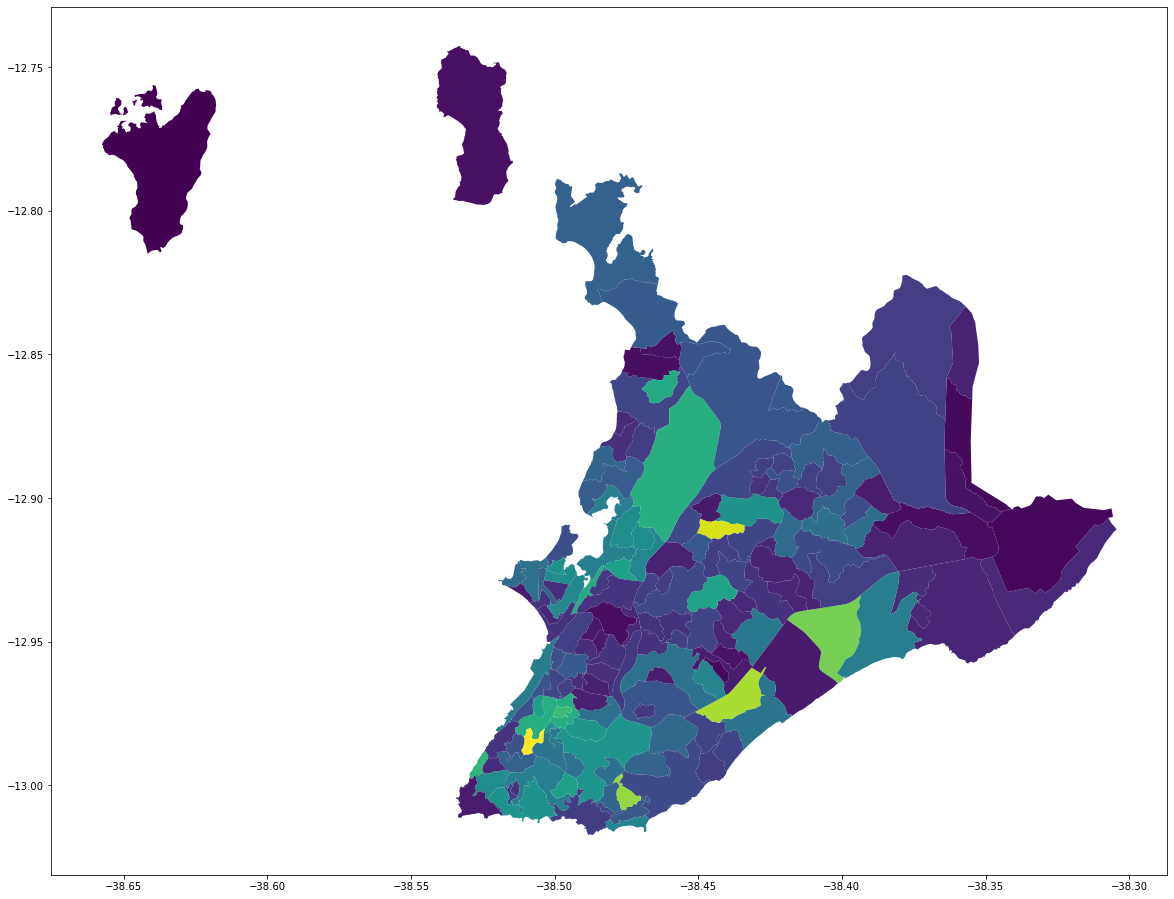

In [36]:
fig, ax = plt.subplots(figsize = [20,20])
nb.plot(ax = ax, column='PP');
plt.show();

# (4) Indicadores Socioeconômicos:

**(a) Densidade Demográfica (Censo 2010):**

In [37]:
pop_ssa = pd.read_excel("pop_ssa.xlsx", decimal = ",")
pop_ssa.head()

,Código,Bairro,Cod_Pref,Periodo,Area_m²,Pop_Total,Pop_H%,Pop_M%,Dens_Dmgf,Pop50-64%,Pop>65%,Pop>50%,Pop50-64,Pop>65,Tot>50
0,1,Acupe,14,2010,512476.74,11213,0.4575,0.5425,218.80,0.1535,0.0777,0.2312,1721.1955,871.2501,2592.4456
1,2,Aeroporto,59,2010,10116033.63,0,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,3,Águas Claras,40,2010,3548530.06,37029,0.4866,0.5134,104.35,0.0987,0.0302,0.1289,1106.7231,338.6326,1445.3557
3,4,Alto da Terezinha,29,2010,943053.59,14010,0.4719,0.5281,148.56,0.1138,0.0442,0.1580,1276.0394,495.6146,1771.6540
4,5,Alto das Pombas,91,2010,133995.77,3823,0.4476,0.5524,285.32,0.1324,0.0672,0.1996,1484.6012,753.5136,2238.1148


In [38]:
nb['dd'] = 0

In [39]:
for index, row in pop_ssa.iterrows():
        nb.loc[nb['Nome_Bairr']==row['Bairro'],'dd'] = row['Dens_Dmgf']

**(b) Percentual de Idosos (Censo 2010):**

In [40]:
idosos = pd.read_excel("pop_ssa.xlsx", decimal = ",")

In [41]:
nb['id'] = 0

In [42]:
for index, row in idosos.iterrows():
        nb.loc[nb['Nome_Bairr']==row['Bairro'],'id'] = row['Pop>65%']

**(c) Indicadores do IVS (IPEA):**

In [43]:
ivs_rms = pd.read_excel('ivs_rms.xlsx', decimal = ",")

In [44]:
ivs_rms = ivs_rms[ivs_rms['ano']==2010].reset_index(drop=True)

In [45]:
ivs_rms['UDH_ATLAS'] = ivs_rms['UDH_ATLAS'].astype(str)

In [46]:
udh = pd.merge(udh, ivs_rms[['UDH_ATLAS','idhm','ivs','ivs_infraestrutura_urbana','ivs_capital_humano',
                             'ivs_renda_e_trabalho','t_sem_agua_esgoto','t_densidadem2']], on='UDH_ATLAS', how='outer')
udh.head()

,UDH_ATLAS,CODIGO_MUN,NM_MUNICIP,REGIONAL,geometry,idhm,ivs,ivs_infraestrutura_urbana,ivs_capital_humano,ivs_renda_e_trabalho,t_sem_agua_esgoto,t_densidadem2
0,1290570100001,2905701,CAMAÇARI,None,"POLYGON ((-38.03061 -12.59706, -38.03061 -12.5...",0.880,0.155,0.134,0.219,0.113,0.03,9.89
1,1290570100002,2905701,CAMAÇARI,None,"POLYGON ((-38.10235 -12.68548, -38.10269 -12.6...",0.880,0.153,0.134,0.212,0.113,0.03,9.89
2,1290570100003,2905701,CAMAÇARI,None,"POLYGON ((-38.28208 -12.85833, -38.28221 -12.8...",0.880,0.148,0.134,0.199,0.113,0.03,9.89
3,1290570100004,2905701,CAMAÇARI,None,"POLYGON ((-38.26493 -12.83496, -38.26658 -12.8...",0.817,0.232,0.245,0.203,0.249,1.72,15.09
4,1290570100007,2905701,CAMAÇARI,None,"POLYGON ((-38.18422 -12.77892, -38.18524 -12.7...",0.817,0.235,0.245,0.210,0.249,1.72,15.09


**(c1) Interseções entre bairros e zonas de tráfego:**

In [47]:
I_ub = np.zeros((len(udh),len(nb)))

In [48]:
for i in np.arange(len(udh)):
    for j in np.arange(len(nb)):
        I_ub[i,j] = udh.loc[i,'geometry'].intersection(nb.loc[j,'geometry']).area

**(c2) Indicadores por bairros:**

In [49]:
idhm_b = [None] * len(nb)
ivs_b = [None] * len(nb)
ivs_iu_b = [None] * len(nb)
ivs_ch_b = [None] * len(nb)
ivs_rt_b = [None] * len(nb)
sae_b = [None] * len(nb)
pm2_b = [None] * len(nb)

In [50]:
for i in np.arange(len(nb)):
    area = I_ub[I_ub[:,i]>0,i]
    if len(area) == 1:
        idhm_b[i] = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'idhm']
        ivs_b[i] = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs']
        ivs_iu_b[i] = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs_infraestrutura_urbana']
        ivs_ch_b[i] = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs_capital_humano']
        ivs_rt_b[i] = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs_renda_e_trabalho']
        sae_b[i] = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'t_sem_agua_esgoto']
        pm2_b[i] = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'t_densidadem2']
    else:
        idhm = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'idhm'].values
        ivs = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs'].values
        ivs_iu = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs_infraestrutura_urbana'].values
        ivs_ch = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs_capital_humano'].values
        ivs_rt = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'ivs_renda_e_trabalho'].values
        sae = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'t_sem_agua_esgoto'].values
        pm2 = udh.loc[np.squeeze(np.argwhere(I_ub[:,i]>0)),'t_densidadem2']
        idhm_b[i] = sum([x * y for x, y in zip(list(idhm),list(area))])/sum(list(area))
        ivs_b[i] = sum([x * y for x, y in zip(list(ivs),list(area))])/sum(list(area))
        ivs_iu_b[i] = sum([x * y for x, y in zip(list(ivs_iu),list(area))])/sum(list(area))
        ivs_ch_b[i] = sum([x * y for x, y in zip(list(ivs_ch),list(area))])/sum(list(area))
        ivs_rt_b[i] = sum([x * y for x, y in zip(list(ivs_rt),list(area))])/sum(list(area))
        sae_b[i] = sum([x * y for x, y in zip(list(sae),list(area))])/sum(list(area))
        pm2_b[i] = sum([x * y for x, y in zip(list(pm2),list(area))])/sum(list(area))

In [51]:
nb['idhm'] = idhm_b
nb['ivs'] = ivs_b
nb['ivs_iu'] = ivs_iu_b
nb['ivs_ch'] = ivs_ch_b
nb['ivs_rt'] = ivs_rt_b
nb['sae'] = sae_b
nb['pm2'] = pm2_b

In [52]:
udh.to_file('udh.shp')

**(d) Gráficos de Dispersão e Correlações:**

Normalização dos Indicadores Socioeconômicos:

In [53]:
nb['dd'] = (nb['dd']-min(nb['dd']))/((max(nb['dd'])-min(nb['dd'])))
nb['id'] = (nb['id']-min(nb['id']))/((max(nb['id'])-min(nb['id'])))
nb['inv_idhm'] = 1 - nb['idhm']
nb['idhm'] = (nb['idhm']-min(nb['idhm']))/((max(nb['idhm'])-min(nb['idhm'])))
nb['inv_idhm'] = (nb['inv_idhm']-min(nb['inv_idhm']))/((max(nb['inv_idhm'])-min(nb['inv_idhm'])))
nb['ivs'] = (nb['ivs']-min(nb['ivs']))/((max(nb['ivs'])-min(nb['ivs'])))
nb['ivs_iu'] = (nb['ivs_iu']-min(nb['ivs_iu']))/((max(nb['ivs_iu'])-min(nb['ivs_iu'])))
nb['ivs_ch'] = (nb['ivs_ch']-min(nb['ivs_ch']))/((max(nb['ivs_ch'])-min(nb['ivs_ch'])))
nb['ivs_rt'] = (nb['ivs_rt']-min(nb['ivs_rt']))/((max(nb['ivs_rt'])-min(nb['ivs_rt'])))
nb['sae'] = (nb['sae']-min(nb['sae']))/((max(nb['sae'])-min(nb['sae'])))
nb['pm2'] = (nb['pm2']-min(nb['pm2']))/((max(nb['pm2'])-min(nb['pm2'])))

In [54]:
df = pd.concat([nb['PP'],nb['dd'],nb['id'],nb['idhm'],nb['ivs'],nb['ivs_iu'],
               nb['ivs_ch'],nb['ivs_rt'],nb['sae'],nb['pm2']], axis = 1)

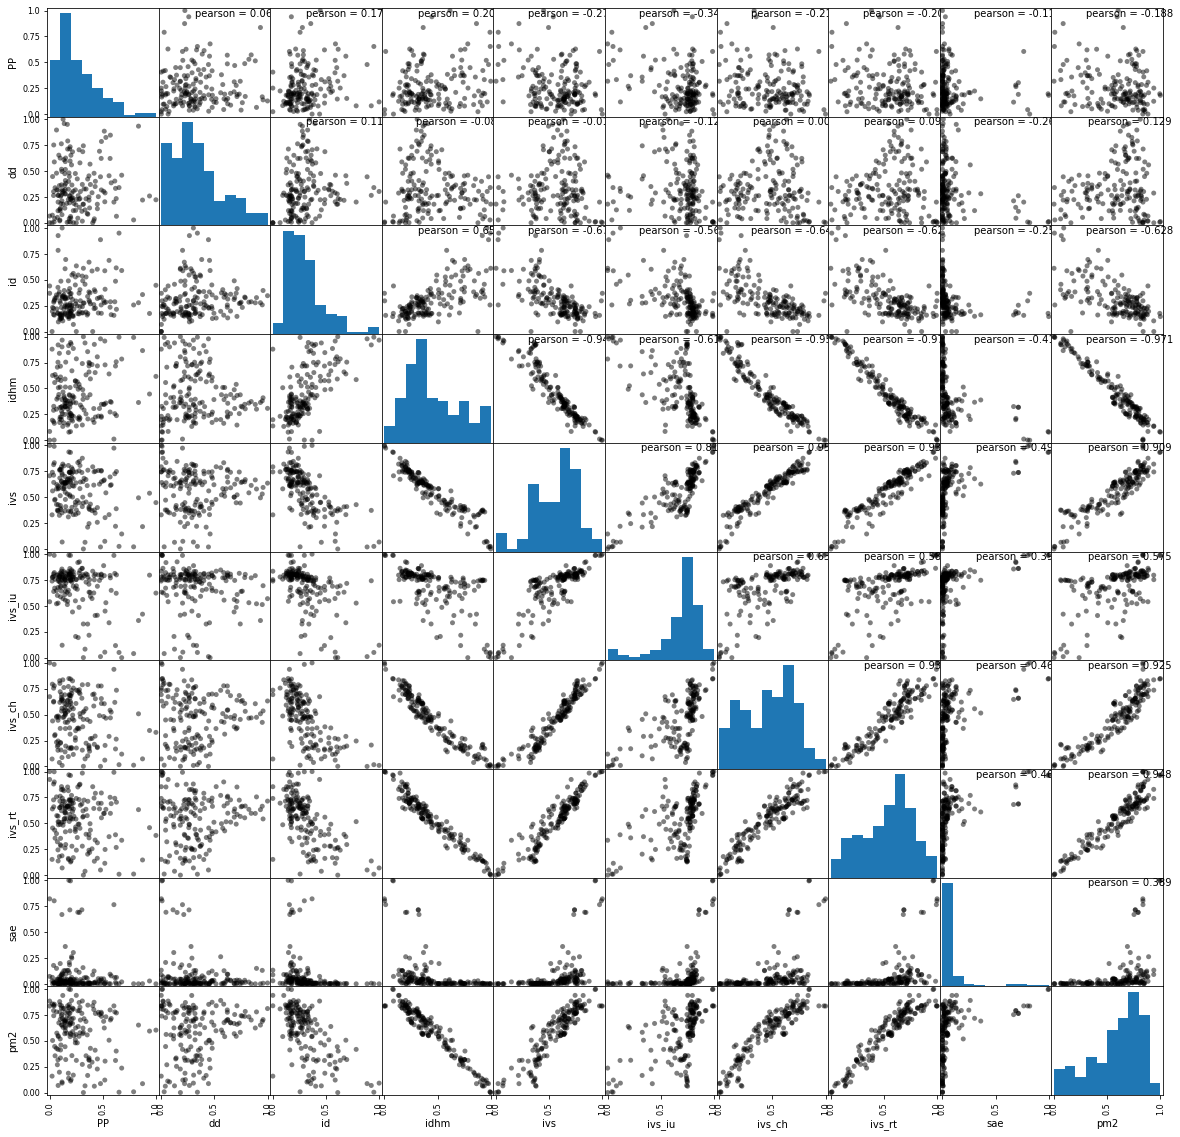

In [55]:
from pandas.plotting import scatter_matrix
axes = scatter_matrix(df, alpha=0.5, figsize = (20,20), s = 100, c = 'k')
corr = np.array(df.corr())
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("pearson = %.3f" %corr[i,j], (0.70, 0.95), xycoords='axes fraction', ha='center', va='center');
plt.show();

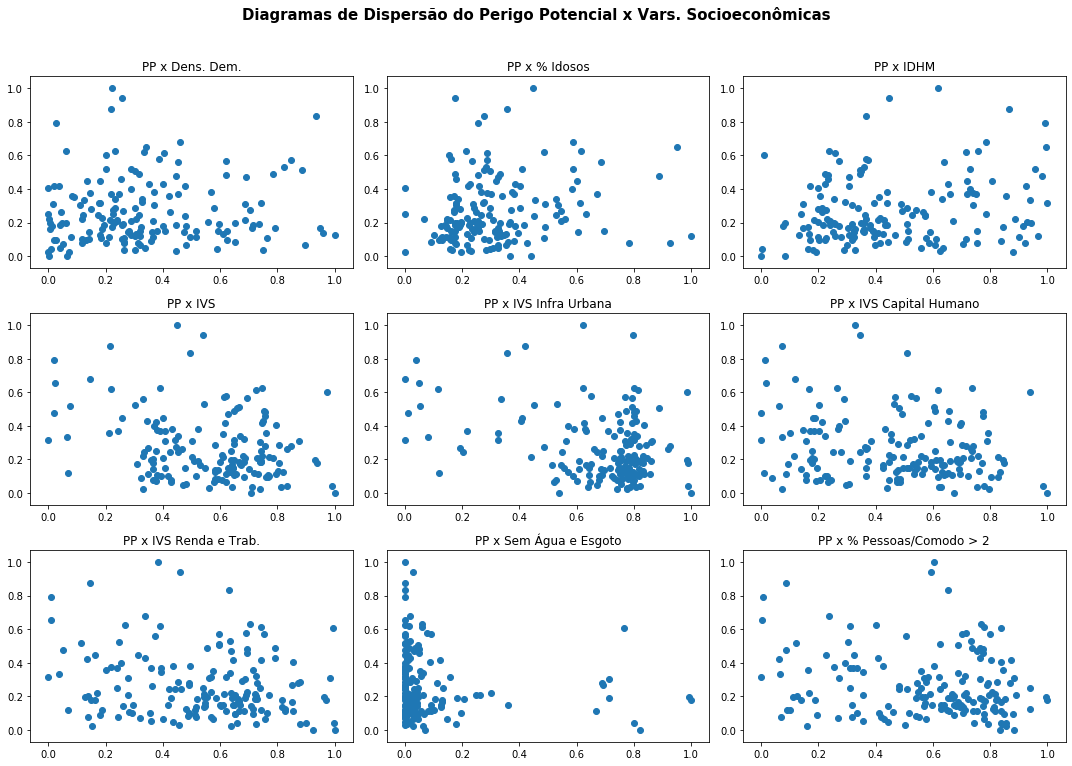

In [56]:
fig, [[ax0,ax1,ax2],[ax3,ax4,ax5],[ax6,ax7,ax8]] = plt.subplots(3,3, figsize = (15,10))
fig.suptitle('Diagramas de Dispersão do Perigo Potencial x Vars. Socioeconômicas', y = 1.06, fontweight='bold', fontsize = 15)
ax0.scatter(nb.dd,nb.PP); ax1.scatter(nb.id,nb.PP); ax2.scatter(nb.idhm,nb.PP); ax3.scatter(nb.ivs,nb.PP); 
ax4.scatter(nb.ivs_iu,nb.PP);  ax5.scatter(nb.ivs_ch,nb.PP); ax6.scatter(nb.ivs_rt,nb.PP); ax7.scatter(nb.sae,nb.PP); 
ax8.scatter(nb.pm2,nb.PP);
ax0.set_title('PP x Dens. Dem.'); ax1.set_title('PP x % Idosos'); ax2.set_title('PP x IDHM'); 
ax3.set_title('PP x IVS'); ax4.set_title('PP x IVS Infra Urbana'); ax5.set_title('PP x IVS Capital Humano'); 
ax6.set_title('PP x IVS Renda e Trab.'); ax7.set_title('PP x Sem Água e Esgoto'); ax8.set_title('PP x % Pessoas/Comodo > 2'); 
#ax4.set_title('Dist. Viagens')
#fig.delaxes(ax5)
fig.tight_layout();
plt.show();

# (5) Indicadores de Risco

In [57]:
R_dd = nb['PP']*nb['dd']
R_idosos = nb['PP']*nb['id']
R_idhm = nb['PP']*nb['inv_idhm']
R_ivs = nb['PP']*nb['ivs']
R_ivs_iu = nb['PP']*nb['ivs_iu']
R_ivs_ch = nb['PP']*nb['ivs_ch']
R_ivs_rt = nb['PP']*nb['ivs_rt']
R_sae = nb['PP']*nb['sae']
R_pm2 = nb['PP']*nb['pm2']

In [58]:
nb['R_dd'] = R_dd; nb['R_idosos'] = R_idosos; nb['R_ivs'] = R_ivs; nb['R_idhm'] = R_idhm
nb['R_ivs_iu'] = R_ivs_iu; nb['R_ivs_ch'] = R_ivs_ch; nb['R_ivs_rt'] = R_ivs_rt; nb['R_sae'] = R_sae; nb['R_pm2'] = R_pm2;   

*Salvando arquivo dos bairros*

In [59]:
nb.to_file('covid_bairros.shp')

**10 bairros mais prioritários por indicador:**

**(a) PP:**

In [60]:
b = list(nb.loc[nb['PP'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pop_ssa['Bairro_ord'] = pd.Categorical(pop_ssa['Bairro'],categories=list(b), ordered=True)
pd.DataFrame(list(zip(b, pop_ssa.sort_values('Bairro_ord')[:10].Pop_Total)), columns = ['Bairro','População'])

,Bairro,População
0,Tororó,4717
1,Vila Canária,11218
2,Imbuí,26540
3,Santa Cruz,27083
4,Patamares,6156
5,Santo Agostinho,4796
6,Vitória,5225
7,Pirajá,33341
8,Nazaré,12571
9,Matatu,10542


**(b) R_idosos:**

In [61]:
b = list(nb.loc[nb['R_idosos'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pop_ssa['Bairro_ord'] = pd.Categorical(pop_ssa['Bairro'],categories=list(b), ordered=True)
pd.DataFrame(list(zip(b, pop_ssa.sort_values('Bairro_ord')[:10].Pop_Total)), columns = ['Bairro','População'])

,Bairro,População
0,Vitória,5225
1,Tororó,4717
2,Graça,18454
3,Santo Agostinho,4796
4,Nazaré,12571
5,Saúde,6232
6,Imbuí,26540
7,Ondina,20298
8,Matatu,10542
9,Amaralina,4125


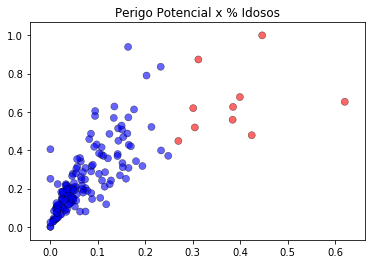

In [62]:
b_crit = list(nb.loc[nb['R_idosos'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pc = ['r' if nb.loc[i,'Nome_Bairr'] in b_crit else 'b' for i in np.arange(len(nb))]
fig, ax = plt.subplots();
ax.scatter(nb['R_idosos'], nb['PP'], c = pc, edgecolor = 'k', linewidth = .5, alpha = 0.6, s = 50);
ax.set_title('Perigo Potencial x % Idosos');
#x_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].ivs);
#y_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].S);
#for i in np.arange(len(b_crit)):
#        ax.text(x_coords[i], y_coords[i], b_crit[i], horizontalalignment='left', fontsize = 10);
#plt.show();
plt.show();

**(c) R_dd:**

In [63]:
b = list(nb.loc[nb['R_dd'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pop_ssa['Bairro_ord'] = pd.Categorical(pop_ssa['Bairro'],categories=list(b), ordered=True)
pd.DataFrame(list(zip(b, pop_ssa.sort_values('Bairro_ord')[:10].Pop_Total)), columns = ['Bairro','População'])

,Bairro,População
0,Santa Cruz,27083
1,Engenho Velho da Federação,24555
2,Mangueira,12310
3,Cosme de Farias,38341
4,Massaranduba,20160
5,Boa Vista de São Caetano,17688
6,Uruguai,30370
7,Santo Agostinho,4796
8,Marechal Rondon,19470
9,Saúde,6232


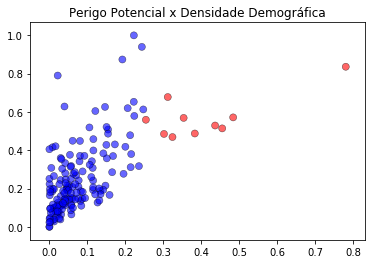

In [64]:
b_crit = list(nb.loc[nb['R_dd'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pc = ['r' if nb.loc[i,'Nome_Bairr'] in b_crit else 'b' for i in np.arange(len(nb))]
fig, ax = plt.subplots();
ax.scatter(nb['R_dd'], nb['PP'], c = pc, edgecolor = 'k', linewidth = .5, alpha = 0.6, s = 50);
ax.set_title('Perigo Potencial x Densidade Demográfica');
#x_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].ivs);
#y_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].S);
#for i in np.arange(len(b_crit)):
#        ax.text(x_coords[i], y_coords[i], b_crit[i], horizontalalignment='left', fontsize = 10);
#plt.show();
plt.show();

**(d) R_idhm:**

In [65]:
b = list(nb.loc[nb['R_idhm'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pop_ssa['Bairro_ord'] = pd.Categorical(pop_ssa['Bairro'],categories=list(b), ordered=True)
pd.DataFrame(list(zip(b, pop_ssa.sort_values('Bairro_ord')[:10].Pop_Total)), columns = ['Bairro','População'])

,Bairro,População
0,Nova Constituinte,9410
1,Santa Cruz,27083
2,Vila Canária,11218
3,Pirajá,33341
4,Santa Luzia,7702
5,Boa Vista de São Caetano,17688
6,Tororó,4717
7,Alto do Cabrito,17051
8,Marechal Rondon,19470
9,Sussuarana,28809


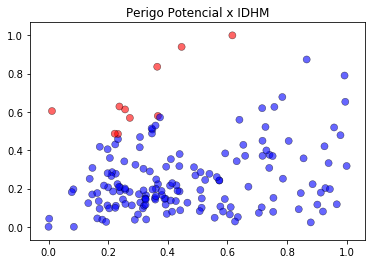

In [66]:
b_crit = list(nb.loc[nb['R_idhm'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pc = ['r' if nb.loc[i,'Nome_Bairr'] in b_crit else 'b' for i in np.arange(len(nb))]
fig, ax = plt.subplots();
#
ax.scatter(nb['idhm'],nb['PP'], c = pc, edgecolor = 'k', linewidth = .5, alpha = 0.6, s = 50);
ax.set_title('Perigo Potencial x IDHM');
#x_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].ivs);
#y_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].S);
#for i in np.arange(len(b_crit)):
#        ax.text(x_coords[i], y_coords[i], b_crit[i], horizontalalignment='left', fontsize = 10);
#plt.show();
#bbox=dict(facecolor='red', alpha=0.5)

**(e) R_ivs:**

In [67]:
b = list(nb.loc[nb['R_ivs'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pop_ssa['Bairro_ord'] = pd.Categorical(pop_ssa['Bairro'],categories=list(b), ordered=True)
pd.DataFrame(list(zip(b, pop_ssa.sort_values('Bairro_ord')[:10].Pop_Total)), columns = ['Bairro','População'])

,Bairro,População
0,Nova Constituinte,9410
1,Vila Canária,11218
2,Pirajá,33341
3,Tororó,4717
4,Santa Luzia,7702
5,Santa Cruz,27083
6,Boa Vista de São Caetano,17688
7,Marechal Rondon,19470
8,Alto do Cabrito,17051
9,Sussuarana,28809


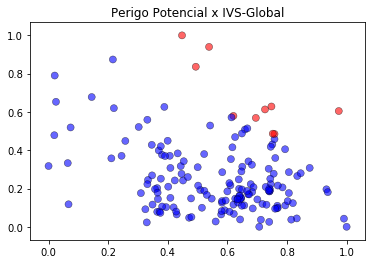

In [68]:
b_crit = list(nb.loc[nb['R_ivs'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pc = ['r' if nb.loc[i,'Nome_Bairr'] in b_crit else 'b' for i in np.arange(len(nb))]
fig, ax = plt.subplots();
#
ax.scatter(nb['ivs'],nb['PP'], c = pc, edgecolor = 'k', linewidth = .5, alpha = 0.6, s = 50);
ax.set_title('Perigo Potencial x IVS-Global');
#x_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].ivs);
#y_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].S);
#for i in np.arange(len(b_crit)):
#        ax.text(x_coords[i], y_coords[i], b_crit[i], horizontalalignment='left', fontsize = 10);
#plt.show();
#bbox=dict(facecolor='red', alpha=0.5)

**(f) R_pm2:**

In [69]:
b = list(nb.loc[nb['R_pm2'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pop_ssa['Bairro_ord'] = pd.Categorical(pop_ssa['Bairro'],categories=list(b), ordered=True)
pd.DataFrame(list(zip(b, pop_ssa.sort_values('Bairro_ord')[:10].Pop_Total)), columns = ['Bairro','População'])

,Bairro,População
0,Tororó,4717
1,Vila Canária,11218
2,Santa Cruz,27083
3,Nova Constituinte,9410
4,Pirajá,33341
5,Santa Luzia,7702
6,Boa Vista de São Caetano,17688
7,Sussuarana,28809
8,Engenho Velho da Federação,24555
9,Cosme de Farias,38341


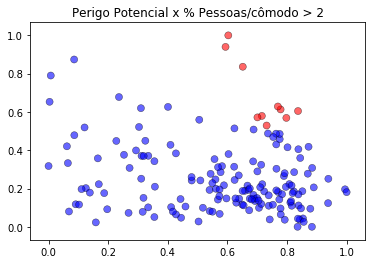

In [70]:
b_crit = list(nb.loc[nb['R_pm2'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pc = ['r' if nb.loc[i,'Nome_Bairr'] in b_crit else 'b' for i in np.arange(len(nb))]
fig, ax = plt.subplots();
#
ax.scatter(nb['pm2'],nb['PP'], c = pc, edgecolor = 'k', linewidth = .5, alpha = 0.6, s = 50);
ax.set_title('Perigo Potencial x % Pessoas/cômodo > 2');
#x_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].ivs);
#y_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].S);
#for i in np.arange(len(b_crit)):
#        ax.text(x_coords[i], y_coords[i], b_crit[i], horizontalalignment='left', fontsize = 10);
#plt.show();
#bbox=dict(facecolor='red', alpha=0.5)

**(g) R_sae:**

In [71]:
b = list(nb.loc[nb['R_sae'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pop_ssa['Bairro_ord'] = pd.Categorical(pop_ssa['Bairro'],categories=list(b), ordered=True)
pd.DataFrame(list(zip(b, pop_ssa.sort_values('Bairro_ord')[:10].Pop_Total)), columns = ['Bairro','População'])

,Bairro,População
0,Nova Constituinte,9410
1,Cajazeiras XI,16899
2,Cassange,4633
3,Palestina,6007
4,Valéria,26210
5,Nova Esperança,6732
6,Cajazeiras X,8513
7,Cajazeiras VIII,13013
8,Nova Brasília,16716
9,São Marcos,28591


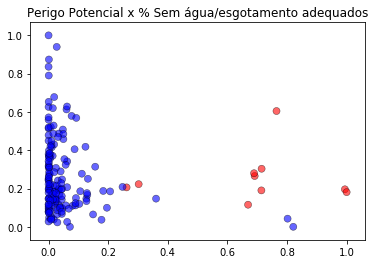

In [72]:
b_crit = list(nb.loc[nb['R_sae'].sort_values(ascending=False)[:10].index,'Nome_Bairr'])
pc = ['r' if nb.loc[i,'Nome_Bairr'] in b_crit else 'b' for i in np.arange(len(nb))]
fig, ax = plt.subplots();
#
ax.scatter(nb['sae'],nb['PP'], c = pc, edgecolor = 'k', linewidth = .5, alpha = 0.6, s = 50);
ax.set_title('Perigo Potencial x % Sem água/esgotamento adequados');
#x_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].ivs);
#y_coords = list(nb[nb['Nome_Bairr'].isin(b_crit)].S);
#for i in np.arange(len(b_crit)):
#        ax.text(x_coords[i], y_coords[i], b_crit[i], horizontalalignment='left', fontsize = 10);
#plt.show();
#bbox=dict(facecolor='red', alpha=0.5)

# Referências

[1] FERGUSON, Neil M. et al. Impact of non-pharmaceutical interventions (NPIs) to reduce COVID-19 mortality and healthcare demand. WHO Collaborating Centre for Infectious Disease Modelling, MRC Centre for Global Infectious Disease Analysis, Abdul Latif Jameel Institute for Disease and Emergency Analytics, Imperial College London. DOI: https://doi. org/10.25561/77482, 2020.

[2] Patrick GT Walker, Charles Whittaker, Oliver Watson et al. The Global Impact of COVID-19 and Strategies for Mitigation and Suppression. WHO Collaborating Centre for Infectious Disease Modelling, MRC Centre for Global Infectious Disease Analysis, Abdul Latif Jameel Institute for Disease and Emergency Analytics, Imperial College London (2020).

[3] WORLD ECONOMIC FORUM. WHO coronavirus briefing: Isolation, testing and tracing comprise the 'backbone' of response. Disponível em: https://www.weforum.org/agenda/2020/03/testing-tracing-backbone-who-coronavirus-wednesdays-briefing/. Acessado em 27/03/2020.

[4] SPOSITO, M.E.B., GUIMARÃES, R. B. Por que a circulação de pessoas tem peso na difusão da pandemia. Disponível em: https://www2.unesp.br/portal#!/noticia/35626/por-que-a-circulacao-de-pessoas-tem-peso-na-difusao-da-pandemia. Acessado em 27/03/2020.

[5] TATEM, A. J.; ROGERS, D. J.; HAY, S. I. Global Transport Networks and Infectious Disease Spread. Advances in Parasitology. Europe PMC Funders, 2006. 

[6] KRAEMER, M. U. G. et al. The effect of human mobility and control measures on the COVID-19 epidemic in China. Science, p. eabb4218, 25 mar. 2020.

[7] UFSC. Universidade Federal de Santa Catarina. Centro Universitário de Pesquisa e Estudos sobre Desastres. Capacitação básica em Defesa Civil. 5. ed. Florianópolis: Centro de Estudos Pesquisas sobre Desastres/Universidade Federal de Santa Catarina - CEPED/UFSC, 2014.

[8] GUIMARÃES, R. B.; GUERREIRO J. A. S.; PEIXOTO, J. A. S. Considerações sobre os riscos ambientais e urbanos no tocante aos desastres e emergências. VERACIDADE, Salvador, v.4, n.7, p. 51-65, mai 2008. 

[9] COSTA, M. A. MARGUTI, B. O. Atlas da vulnerabilidade social nos municípios brasileiros. IPEA 2015.